In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [4]:
# Update the path below to the correct location of your CSV file
df = pd.read_csv('dataset\\Mall_Customers.csv')
df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
X = df[["Annual Income (k$)", "Spending Score (1-100)"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

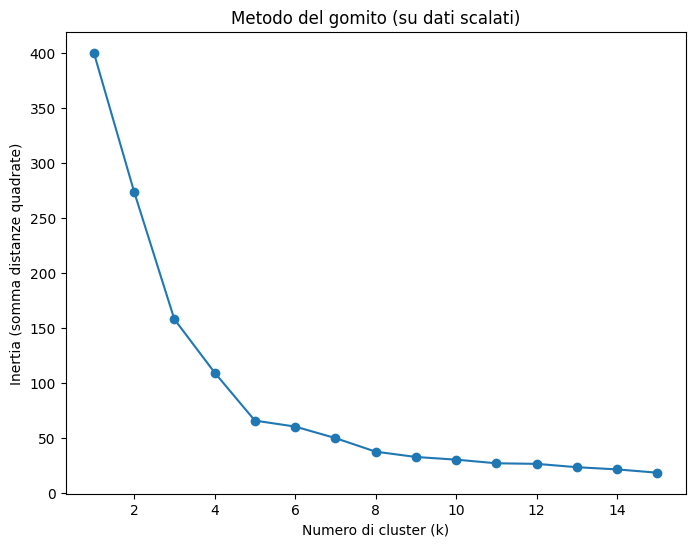

In [27]:
wcss = []
K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Grafico del gomito
plt.figure(figsize=(8,6))
plt.plot(K_range, wcss, marker="o")
plt.xlabel("Numero di cluster (k)")
plt.ylabel("Inertia (somma distanze quadrate)")
plt.title("Metodo del gomito (su dati scalati)")
plt.show()

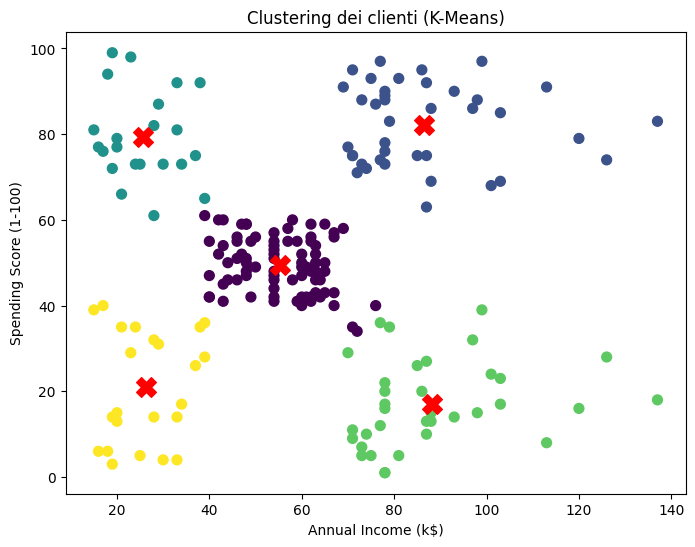

In [26]:
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], 
            c=df["Cluster"], cmap="viridis", s=50)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], c="red", s=200, marker="X") # centroidi
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Clustering dei clienti (K-Means)")
plt.show()


Identificare il cluster che rappresenta i clienti ad alto potenziale (alto reddito e alto punteggio di spesa).

In [28]:
cluster_summary = df.groupby("Cluster")[["Annual Income (k$)", "Spending Score (1-100)"]].mean()

# Calcolo di un indice di "potenziale" come combinazione di reddito e spesa
cluster_summary["Potenziale"] = (
    cluster_summary["Annual Income (k$)"] / cluster_summary["Annual Income (k$)"].max()
    + cluster_summary["Spending Score (1-100)"] / cluster_summary["Spending Score (1-100)"].max()
)

# Identifica il cluster migliore
high_potential = cluster_summary.sort_values(by="Potenziale", ascending=False).head(1)

print("Medie dei cluster:\n", cluster_summary)
print("\nCluster ad alto potenziale:\n", high_potential)


Medie dei cluster:
          Annual Income (k$)  Spending Score (1-100)  Potenziale
Cluster                                                        
0                 55.296296               49.518519    1.229884
1                 86.538462               82.128205    1.981162
2                 25.727273               79.363636    1.258031
3                 88.200000               17.114286    1.208385
4                 26.304348               20.913043    0.552874

Cluster ad alto potenziale:
          Annual Income (k$)  Spending Score (1-100)  Potenziale
Cluster                                                        
1                 86.538462               82.128205    1.981162


Calcolare la distanza media dei punti dal centroide del proprio cluster per valutare la compattezza dei gruppi.

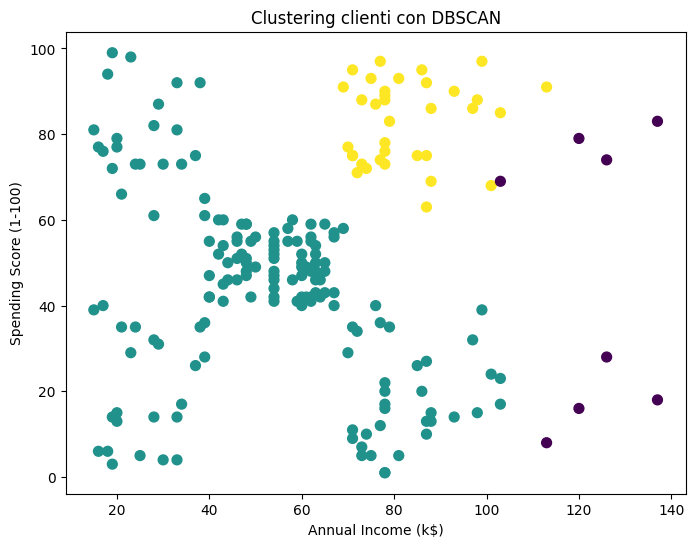

DBSCAN ha trovato 2 cluster (più eventuali outlier).
Cluster_DBSCAN
 0    157
 1     35
-1      8
Name: count, dtype: int64


In [21]:
# Applica DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # parametri di base, vanno calibrati
labels = dbscan.fit_predict(X_scaled)

# Aggiungiamo le etichette al dataset
df["Cluster_DBSCAN"] = labels

# Visualizziamo il clustering con le due variabili principali
plt.figure(figsize=(8,6))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"],
            c=df["Cluster_DBSCAN"], cmap="viridis", s=50)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Clustering clienti con DBSCAN")
plt.show()

# Numero di cluster trovati (esclusi gli outlier = -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN ha trovato {n_clusters} cluster (più eventuali outlier).")

# Conteggio per cluster
print(df["Cluster_DBSCAN"].value_counts())